In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from typing import Optional


file_path: str = "../dataset"
files: tuple[str, ...] = ("connections", "devices", "processes", "profiles")

dataset: dict[str, pd.DataFrame] = {}
for file in files:
    dataset[file] = pd.read_csv(f"{file_path}/{file}.csv", sep="\t")

A.)


Connections description


In [32]:
dataset["connections"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15108 entries, 0 to 15107
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ts                 15108 non-null  object 
 1   imei               15108 non-null  int64  
 2   mwra               15108 non-null  float64
 3   c.dogalize         15108 non-null  float64
 4   c.android.gm       15108 non-null  float64
 5   c.android.youtube  15108 non-null  float64
 6   c.android.chrome   15108 non-null  float64
 7   c.katana           15108 non-null  float64
 8   c.raider           15108 non-null  float64
 9   c.android.vending  15108 non-null  float64
 10  c.UCMobile.x86     15108 non-null  float64
 11  c.updateassist     15108 non-null  float64
 12  c.UCMobile.intl    15108 non-null  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.5+ MB


-   Total Entries: 15,108
-   Total Columns: 13
-   Column Types:
-   11 columns of type float64
-   1 column of type int64
-   1 column of type object
-   There are no missing values in this data


In [33]:
dataset["connections"]["ts"]

0        2018-05-05 10:00:00
1        2018-05-05 10:01:00
2        2018-05-05 10:02:00
3        2018-05-05 10:03:00
4        2018-05-05 10:04:00
                ...         
15103    2018-05-05 20:51:00
15104    2018-05-12 15:15:00
15105    2018-05-08 09:46:00
15106    2018-05-08 20:46:00
15107    2018-05-14 20:56:00
Name: ts, Length: 15108, dtype: object

-   The object column "ts" is date and time


In [34]:
connection_summary = dataset["connections"].describe()
median = (
    dataset["connections"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
connection_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
connection_summary.drop(columns=["imei"], inplace=True)
connection_summary

,mwra,c.dogalize,c.android.gm,c.android.youtube,c.android.chrome,c.katana,c.raider,c.android.vending,c.UCMobile.x86,c.updateassist,c.UCMobile.intl
count,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000
mean,0.625563,10.309496,10.928002,12.141882,10.933567,10.416465,48.846209,49.482347,49.685602,49.822994,49.805628
std,0.483993,2.626325,2.696930,2.225872,2.652465,2.626934,13.031848,28.905578,28.962924,29.030406,28.843199
min,0.000000,0.642300,2.587630,2.348110,2.655890,1.165660,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.434330,8.943805,10.934585,8.965822,8.538965,39.977420,24.570853,24.731063,24.532995,24.735187
50%,1.000000,10.154350,10.844220,12.375635,10.780055,10.263805,48.962015,49.269510,49.300740,49.852925,49.520235
75%,1.000000,12.049473,12.850918,13.642702,12.806403,12.192747,57.737270,74.651803,74.873525,75.301215,74.849797
max,1.000000,20.212930,22.004980,19.587410,21.092210,19.919510,100.000000,100.000000,100.000000,100.000000,100.000000
median,1.000000,10.154350,10.844220,12.375635,10.780055,10.263805,48.962015,49.269510,49.300740,49.852925,49.520235


-   From these tables above we can see imei is a long integer and looks like an Id, if we look at processes table, we can also see same values indicating this could be an Id of device.
-   Another assumption we can make is that columns specifying a connection type (columns starting with c. such as c.android.youtube) have values ranging from 0 to 100, this could indicate that it is a percentage amount of time that the connection was established.


-   First few rows might indicate that the data was sample in a 1 minute interval.
-   Let's look at it closer.


In [35]:
dataset["connections"].sort_values(by="ts", ascending=True)["ts"]

0        2018-05-05 10:00:00
1        2018-05-05 10:01:00
2        2018-05-05 10:02:00
3        2018-05-05 10:03:00
4        2018-05-05 10:04:00
                ...         
14924    2018-05-15 18:44:00
14925    2018-05-15 18:45:00
14926    2018-05-15 18:46:00
14927    2018-05-15 18:47:00
14928    2018-05-15 18:48:00
Name: ts, Length: 15108, dtype: object

-   Now we see it looks like samples are in a 1 minute interval.
-   Let's go further.


In [36]:
times = dataset["connections"].sort_values(by="ts")["ts"]
times = pd.to_datetime(times)

previous_time: Optional[pd.Series] = None

same_times: int = 0
non_minute_differences: int = 0


for current_time in times:
    if previous_time is None:
        previous_time = current_time
        continue

    if (current_time - previous_time).seconds == 0:
        same_times += 1

    elif (current_time - previous_time).seconds != 60:
        non_minute_differences += 1

    previous_time = current_time

print(f"Non minute differences: {non_minute_differences}")
print(f"Same times: {same_times}")

Non minute differences: 0
Same times: 179


-   From this we can see, that there are data every minute, sometimes more than once at the same time.


In [37]:
times = (
    dataset["connections"]
    .groupby(by="imei")[["imei", "ts"]]
    .apply(lambda x: x.sort_values(by="ts", ascending=True))
    .reset_index(drop=True)
)
times

,imei,ts
0,359043379931766007,2018-05-05 11:14:00
1,359043379931766007,2018-05-05 15:58:00
2,359043379931766007,2018-05-05 19:33:00
3,359043379931766007,2018-05-05 19:33:00
4,359043379931766007,2018-05-06 01:55:00
...,...,...
15103,8630330696303482493,2018-05-14 12:20:00
15104,8630330696303482493,2018-05-14 23:36:00
15105,8630330696303482493,2018-05-14 23:47:00
15106,8630330696303482493,2018-05-15 07:50:00


-   If we assume that columns starting with "c." are representing percentage amount of time being active during a time window, we need to group them by device serial number (imei) and then look at the time difference.


In [38]:
dataset["connections"]["mwra"].value_counts()

mwra
1.0    9451
0.0    5657
Name: count, dtype: int64

-   mwra is (Malware-related-activity)
-   In data there are only values 1.0 and 0.0 indicating if there was a malware activity in specific time frame.


Devices description


In [39]:
dataset["devices"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    2929 non-null   float64
 1   longitude   2929 non-null   float64
 2   store_name  2929 non-null   object 
 3   code        2929 non-null   object 
 4   location    2929 non-null   object 
 5   imei        2929 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 137.4+ KB


In [40]:
devices_summary = dataset["devices"].describe()
median = (
    dataset["devices"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
devices_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
devices_summary.drop(columns=["imei"], inplace=True)
devices_summary

,latitude,longitude
count,2929.000000,2929.000000
mean,29.279310,11.548748
std,22.929049,73.811177
min,-54.800000,-156.474320
25%,15.460630,-59.133160
50%,36.192780,9.476290
75%,46.083330,73.000000
max,68.798330,178.004170
median,36.192780,9.476290


In [41]:
dataset["devices"].head()

,latitude,longitude,store_name,code,location,imei
0,48.21644,9.02596,Albstadt,DE,Europe/Berlin,863033069630348990
1,12.74409,-8.07257,Kati,ML,Africa/Bamako,3590433799317661677
2,7.83389,-72.47417,Villa del Rosario,CO,America/Bogota,3590433799317661990
3,12.37169,123.62494,Masbate,PH,Asia/Manila,3590433799317661172
4,39.33427,-76.43941,Middle River,US,America/New_York,863033069630348073


-   "store_name" object is a string
-   "code" is string, holding code for state
-   "location" is a string, containing continent and city


Processes description


In [42]:
dataset["processes"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15108 entries, 0 to 15107
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ts                          15108 non-null  object 
 1   imei                        15108 non-null  int64  
 2   mwra                        15108 non-null  float64
 3   p.android.packageinstaller  15108 non-null  float64
 4   p.android.settings          15108 non-null  float64
 5   p.android.documentsui       15108 non-null  float64
 6   p.android.chrome            15108 non-null  float64
 7   p.android.gm                15108 non-null  float64
 8   p.system                    15108 non-null  float64
 9   p.android.externalstorage   15108 non-null  float64
 10  p.android.vending           15108 non-null  float64
 11  p.process.gapps             15108 non-null  float64
 12  p.google                    15108 non-null  float64
 13  p.browser.provider          151

In [43]:
processes_summary = dataset["processes"].describe()
median = (
    dataset["processes"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
processes_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
processes_summary.drop(columns=["imei"], inplace=True)
processes_summary

,mwra,p.android.packageinstaller,p.android.settings,p.android.documentsui,p.android.chrome,p.android.gm,p.system,p.android.externalstorage,p.android.vending,p.process.gapps,...,p.browser.provider,p.android.defcontainer,p.dogalize,p.olauncher,p.simulator,p.inputmethod.latin,p.android.gms,p.notifier,p.katana,p.gms.persistent
count,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,...,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000
mean,0.625563,11.572954,11.499864,10.310165,9.790817,12.771425,10.397043,11.576398,0.062140,50.683308,...,50.072203,47.326426,50.037140,49.640124,50.022306,50.260806,50.272805,49.751673,49.852339,49.573461
std,0.483993,2.636035,2.679572,2.648527,2.436871,1.816167,2.664877,2.713959,1.030622,12.871117,...,13.310724,13.104973,28.833214,28.910236,28.957691,28.843929,28.820311,28.685114,28.967083,29.068352
min,0.000000,2.487240,1.570430,2.279980,0.000000,5.552490,0.616400,2.292350,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.739860,9.656940,8.417333,8.122188,11.547503,8.453595,9.704448,0.000240,42.027770,...,41.272058,38.443713,25.007917,24.370213,24.879258,25.193368,25.569652,25.352768,24.522633,24.168370
50%,1.000000,11.703395,11.619575,10.138660,9.641190,12.781690,10.351115,11.693555,0.001460,50.743580,...,49.965620,47.353845,50.400705,49.551330,50.338015,50.040285,50.465125,49.859050,49.514105,49.986190
75%,1.000000,13.443035,13.414413,12.119515,11.364935,14.001280,12.327390,13.534700,0.010613,59.441673,...,58.825585,56.251165,75.002775,74.764725,74.949060,75.316412,75.275442,74.062057,75.035590,74.764915
max,1.000000,20.415500,20.927500,20.122050,19.855360,19.625710,19.216320,21.071240,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
median,1.000000,11.703395,11.619575,10.138660,9.641190,12.781690,10.351115,11.693555,0.001460,50.743580,...,49.965620,47.353845,50.400705,49.551330,50.338015,50.040285,50.465125,49.859050,49.514105,49.986190


In [44]:
dataset["processes"].head()

,ts,imei,mwra,p.android.packageinstaller,p.android.settings,p.android.documentsui,p.android.chrome,p.android.gm,p.system,p.android.externalstorage,...,p.browser.provider,p.android.defcontainer,p.dogalize,p.olauncher,p.simulator,p.inputmethod.latin,p.android.gms,p.notifier,p.katana,p.gms.persistent
0,2018-05-05 10:00:00,3590433799317661693,1.0,9.23642,14.64737,12.28429,8.10855,11.56273,9.81747,7.96281,...,35.91940,24.95922,21.17604,80.95317,64.67547,55.80378,82.99368,96.45875,95.47350,18.60413
1,2018-05-05 10:01:00,863033069630348362,1.0,12.12539,13.31378,8.53914,8.99158,10.84797,10.73896,12.39776,...,59.79664,48.67044,40.08113,25.00209,86.68513,4.17599,65.28470,11.04057,72.81380,55.76611
2,2018-05-05 10:02:00,863033069630348040,1.0,11.93971,13.62370,13.71940,10.16446,14.61026,10.14790,10.00803,...,37.66953,51.76377,87.50645,8.40823,32.66810,96.13825,4.88761,29.88836,82.48309,18.89299
3,2018-05-05 10:03:00,8630330696303482121,0.0,11.75678,5.40945,10.37504,12.96885,15.71257,13.59185,14.10555,...,47.54273,51.31861,40.91248,46.38488,35.03554,24.37016,69.40371,27.45343,53.48129,80.62817
4,2018-05-05 10:04:00,3590433799317661495,0.0,13.29218,9.88140,10.48243,12.30196,10.07931,14.95220,12.61291,...,44.97460,35.66277,43.71764,14.70324,73.82801,24.01651,55.68464,29.72480,93.90266,79.73910


Profiles description


In [45]:
dataset["profiles"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2571 entries, 0 to 2570
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   username      2571 non-null   object
 1   address       2185 non-null   object
 2   name          2571 non-null   object
 3   user_id       2571 non-null   int64 
 4   job           771 non-null    object
 5   ssn           2571 non-null   object
 6   company       2571 non-null   object
 7   imei          2571 non-null   int64 
 8   registration  2571 non-null   object
 9   residence     900 non-null    object
 10  mail          2571 non-null   object
 11  birthdate     1414 non-null   object
dtypes: int64(2), object(10)
memory usage: 241.2+ KB


In [46]:
profiles_summary = dataset["profiles"].describe()
median = (
    dataset["profiles"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
profiles_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
profiles_summary.drop(columns=["imei"], inplace=True)
profiles_summary

,user_id
count,2571.000000
mean,1294.560482
std,734.696063
min,0.000000
25%,660.500000
50%,1280.000000
75%,1938.000000
max,2570.000000
median,1280.000000


In [47]:
dataset["profiles"].head()

,username,address,name,user_id,job,ssn,company,imei,registration,residence,mail,birthdate
0,nancywagner,Unit 3496 Box 9846\r\nDPO AE 23667,Shelly Thomas,1713,NaN,568-30-2539,"Miller, Kirby and Davis",863033069630348636,02 Aug 2018,NaN,brandonsmith@hotmail.com,2004-12-08
1,millerdakota,"677 Jay Vista Suite 015\r\nBrownhaven, LA 18432",Amy Horn,1886,NaN,395-74-2254,"Gonzalez, Andrade and Robinson",359043379931766007,18 Feb 2022,NaN,keithgibbs@gmail.com,1931-09-11
2,meyerabigail,"3746 Baldwin Estate Suite 335\r\nWest Travis, ...",Leah Campbell,184,NaN,848-91-2310,"Boyle, Taylor and Sampson",8630330696303481487,2021/08/17,NaN,steve72@yahoo.com,1931-11-04
3,timothyhart,"8748 Villarreal Lights\r\nWest Michaelfurt, WA...",Joseph Miller,920,Fast food restaurant manager,247-95-0332,Smith-Rodriguez,8630330696303481156,2023-10-24,"864 Jared Overpass Suite 869\r\nPort Amanda, W...",mfletcher@hotmail.com,1955-01-15
4,jenniferwilliams,"499 Michael Flat\r\nJesseview, HI 05817",Kimberly Williams,2557,NaN,162-02-9998,Ramsey-Fernandez,8630330696303481453,2018-03-19,NaN,ryanmartinez@yahoo.com,1966-09-30


B


-   First we look at the most important column "mwra" and look at it more in depth.


In [48]:
dataset["connections"]["mwra"].value_counts(normalize=True) * 100

mwra
1.0    62.556262
0.0    37.443738
Name: proportion, dtype: float64

-   In "connections" we can see that positive mwra is ~62%, indicating that there are more positive cases and therefore in future when we put it into our model might falsely evaluate some connections. I would say the closer we are to 50/50 the better.


In [49]:
dataset["processes"]["mwra"].value_counts(normalize=True) * 100

mwra
1.0    62.556262
0.0    37.443738
Name: proportion, dtype: float64

-   "mwra" is the same for "processes" as it is for "connections"



## Declaring and Initializing variables for further use.

In [50]:
chrome_data = dataset["connections"]["c.android.chrome"]
chrome_mean = chrome_data.mean()
chrome_std = chrome_data.std()

dogalize_data = dataset["connections"]["c.dogalize"]
dogalize_mean = dogalize_data.mean()
dogalize_std = dogalize_data.std()

gm_data = dataset["connections"]["c.android.gm"]
gm_mean = gm_data.mean()
gm_std = gm_data.std()

youtube_data = dataset["connections"]["c.android.youtube"]
youtube_mean = youtube_data.mean()
youtube_std = youtube_data.std()

katana_data = dataset["connections"]["c.katana"]
katana_mean = katana_data.mean()
katana_std = katana_data.std()

raider_data = dataset["connections"]["c.raider"]
raider_mean = raider_data.mean()
raider_std = raider_data.std()

vending_data = dataset["connections"]["c.android.vending"]
vending_mean = vending_data.mean()
vending_std = vending_data.std()

x86_data = dataset["connections"]["c.UCMobile.x86"]
x86_mean = x86_data.mean()
x86_std = x86_data.std()


updateassist_data = dataset["connections"]["c.updateassist"]
updateassist_mean = updateassist_data.mean()
updateassist_std = updateassist_data.std()

intl_data = dataset["connections"]["c.UCMobile.intl"]
intl_mean = intl_data.mean()
intl_std = intl_data.std()


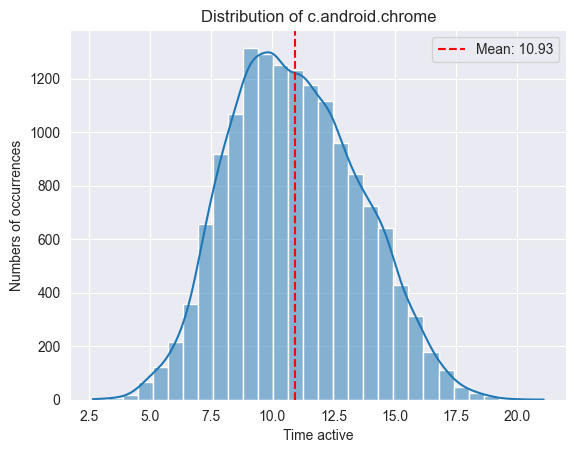

In [51]:
sns.histplot(chrome_data, bins=30, kde=True)
plt.axvline(chrome_mean, color="r", linestyle="--", label=f"Mean: {chrome_mean:.2f}")
plt.title("Distribution of c.android.chrome")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.show()

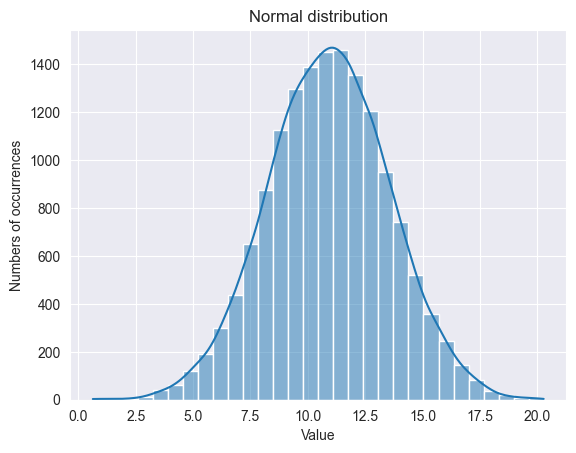

In [52]:
chrome_distribution = stats.norm.rvs(loc=chrome_mean, scale=chrome_std, size=chrome_data.size)
sns.histplot(chrome_distribution, bins=30, kde=True)
plt.title("Normal distribution")
plt.xlabel("Value")
plt.ylabel("Numbers of occurrences")
plt.show()

In [53]:
anderson_test = stats.anderson(chrome_data, dist="norm")
print(anderson_test)

AndersonResult(statistic=np.float64(30.11790341565211), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(10.933566724252053), scale=np.float64(2.6524649720260522))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


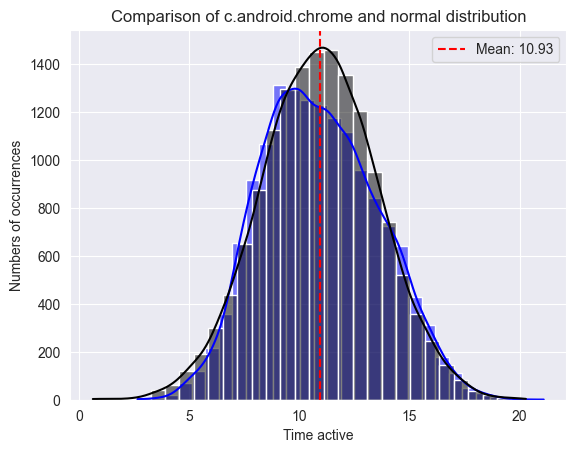

In [54]:
sns.histplot(chrome_data, bins=30, kde=True, color="blue")
sns.histplot(chrome_distribution, bins=30, kde=True, color="black")
plt.axvline(chrome_mean, color="r", linestyle="--", label=f"Mean: {chrome_mean:.2f}")
plt.title("Comparison of c.android.chrome and normal distribution")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.show()

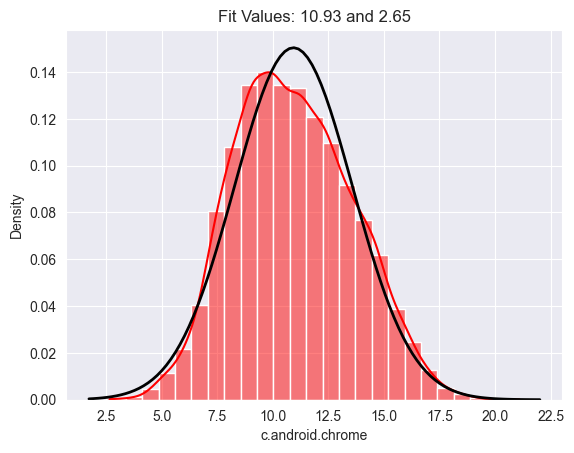

In [55]:
mu, std = stats.norm.fit(chrome_data)

# Create the histogram using seaborn
sns.histplot(data=chrome_data, bins=25, stat="density", kde="True", color="r")

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)

plt.plot(x, p, "k", linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
plt.show()

-   The red line is mean of the data.
-   We can see that the data is approximately symmetric, but has a skew to the right.


In [56]:
chrome_skew = stats.skew(chrome_data)
print(f"Skewness of c.android.chrome: {chrome_skew}")

Skewness of c.android.chrome: 0.20270904314934854


-   Skewness is 0.20270904314934854, therefore this data is approximately symmetric, but has a little bit fatter right tail.


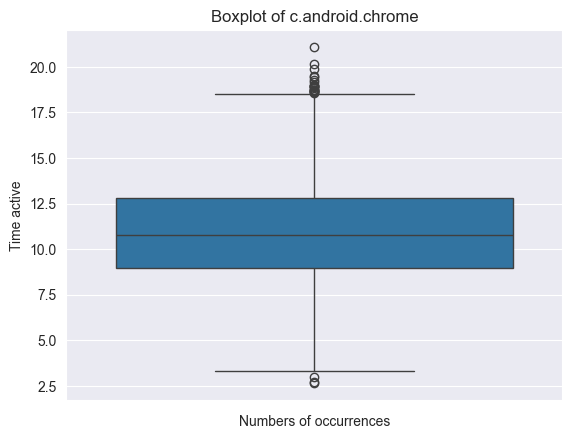

In [57]:
sns.boxplot(data=chrome_data)
plt.title("Boxplot of c.android.chrome")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.show()

-   If we assume the values in columns are active time, we should also look at the range 0-100


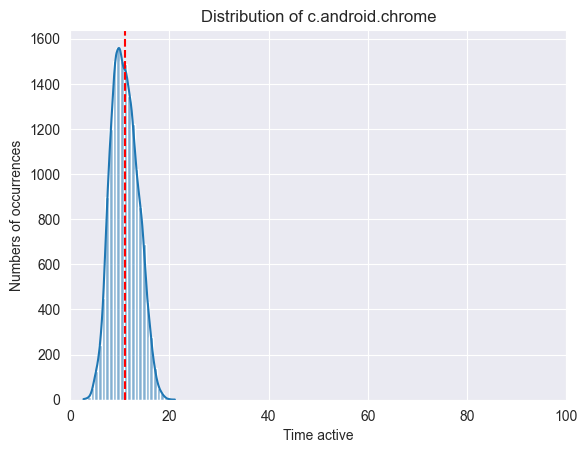

In [58]:
sns.histplot(chrome_data, bins=25, kde=True)
plt.axvline(chrome_mean, color="r", linestyle="--", label=f"Mean: {chrome_mean:.2f}")
plt.xlim(0, 100)
plt.title("Distribution of c.android.chrome")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.show()

-   Here we see that there are little outliers in lower values, but there are quite few of them near maximum value.


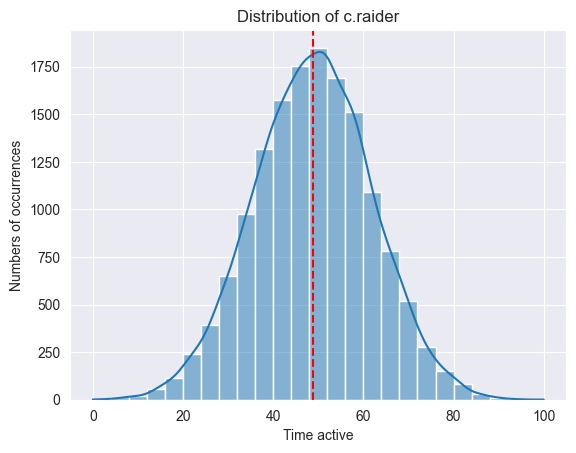

In [59]:
raider_data = dataset["connections"]["c.raider"]

raider_mean = raider_data.mean()

sns.histplot(raider_data, bins=25, kde=True)
plt.axvline(raider_mean, color="r", linestyle="--", label=f"Mean: {raider_mean:.2f}")
plt.title("Distribution of c.raider")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.show()

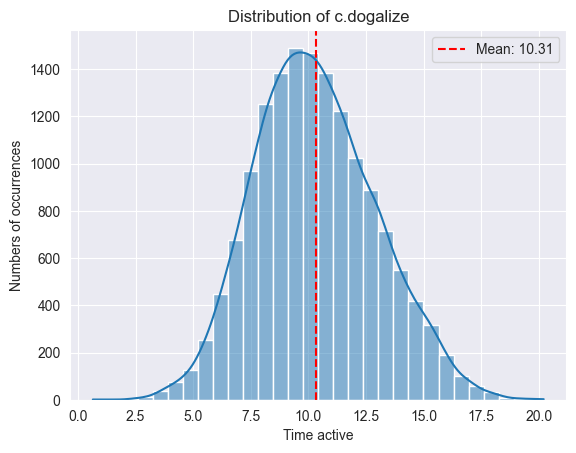

In [60]:
chrome_data = dataset["connections"]["c.dogalize"]

chrome_mean = chrome_data.mean()
chrome_std = chrome_data.std()

sns.histplot(chrome_data, bins=30, kde=True)
plt.axvline(chrome_mean, color="r", linestyle="--", label=f"Mean: {chrome_mean:.2f}")
plt.title("Distribution of c.dogalize")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.show()

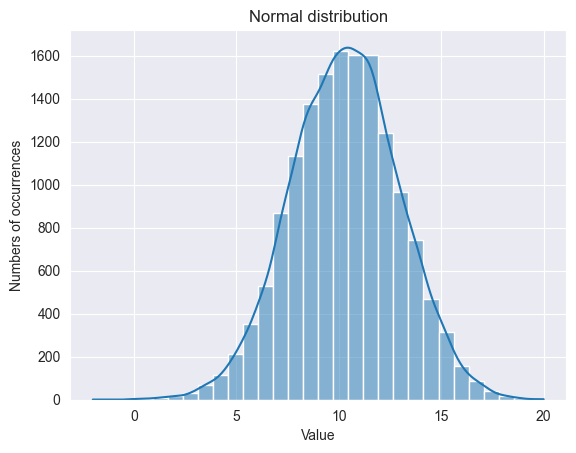

In [61]:
chrome_distribution = stats.norm.rvs(loc=chrome_mean, scale=chrome_std, size=chrome_data.size)
sns.histplot(chrome_distribution, bins=30, kde=True)
plt.title("Normal distribution")
plt.xlabel("Value")
plt.ylabel("Numbers of occurrences")
plt.show()
